In [455]:
import psycopg2
from psycopg2.extras import DictCursor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings("ignore", category=UserWarning,
                        message="pandas only supports SQLAlchemy connectable")

try:
        print("\033[95mconnection to database...")
        conn = psycopg2.connect(
            database='piscineds',
            user='bgales',
            password='mysecretpassword',
            host='localhost'
        )
        cursor = conn.cursor(cursor_factory=DictCursor)
        print('\033[92mconnection with database OK')
        cursor.execute('BEGIN;')
except Exception as e:
    print("\033[91mError: ", e)
    print('\033[93mrollback in progress...\033[0m')
    conn.rollback()

connection to database...
connection with database OK


In [456]:
def hide_ticks_frame():
    plt.tick_params(axis='both', which='both', length=0)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

In [457]:
try:
    print('\033[93mfetching data from database for the first graph...\033[0m')
    df = pd.read_sql_query(
        '''
        WITH freq AS (
            SELECT
                user_id,
                SUM(frequency) AS total_frequency
            FROM (
                SELECT
                    user_id,
                    DATE_TRUNC('month', event_time) AS month,
                    COUNT(*) AS frequency
                FROM
                    customers
                WHERE
                    event_type = 'purchase'
                GROUP BY
                    user_id, DATE_TRUNC('month', event_time)
            ) monthly_freq
            GROUP BY
                user_id
        )
        SELECT
            c.user_id,
            SUM(c.price::numeric) * 0.5 AS total_spent,
            (EXTRACT(EPOCH FROM AGE('2023-02-28', MAX(c.event_time)))
                / (86400 * 30))::NUMERIC(10, 2) AS last_purchase,
            (EXTRACT(EPOCH FROM AGE('2023-02-28', MIN(c.event_time)))
                / (86400 * 30))::NUMERIC(10, 2) AS first_purchase,
            COALESCE(
    f.total_frequency / GREATEST((EXTRACT(EPOCH FROM AGE('2023-01-31', MIN(c.event_time))) / (86400 * 30)),
        1),0) * 0.5 AS frequency
        FROM
            customers c
        LEFT JOIN
            freq f ON c.user_id = f.user_id
        WHERE
            c.event_type = 'purchase'
        GROUP BY
            c.user_id, f.total_frequency
        ORDER BY
            c.user_id;

        ''', conn
    )
    df = df.drop('user_id', axis=1)
    cursor.execute(
        '''
            SELECT COUNT(user_id) FROM customers
            WHERE event_type = 'purchase'
        '''
    )
    customers_nb = cursor.fetchone()[0]
    print('\033[92mdata fetched with success!\033[0m')
except Exception as e:
    print("\033[91mError: ", e)
    print('\033[93mrollback in progress...\033[0m')
    conn.rollback()

fetching data from database for the first graph...
data fetched with success!


In [458]:
scaler = StandardScaler()

# I standardize the data to make the scales uniform across columns.
# This prevents a column with a large scale (e.g., values around 20k)
# from dominating the calculations compared to a column with smaller values (e.g., 10).
scaled = scaler.fit_transform(df)

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(scaled)
cluster = kmeans.fit_predict(scaled)
cluster_centers = kmeans.cluster_centers_

# I reverse the standardization process in order to get the centroïds
# back to their original values.
real_centers = scaler.inverse_transform(cluster_centers)
centers_df = pd.DataFrame(real_centers, columns=df.columns)


   total_spent  last_purchase  first_purchase  frequency
0    20.329410       4.058885        4.156438   1.246287
1    17.743541       0.821852        0.918387   3.384884
2   109.922719       1.149934        3.013088  11.474035
3    20.950044       2.413720        2.868098   2.120904
4   343.606475       0.759122        2.934115  35.816346


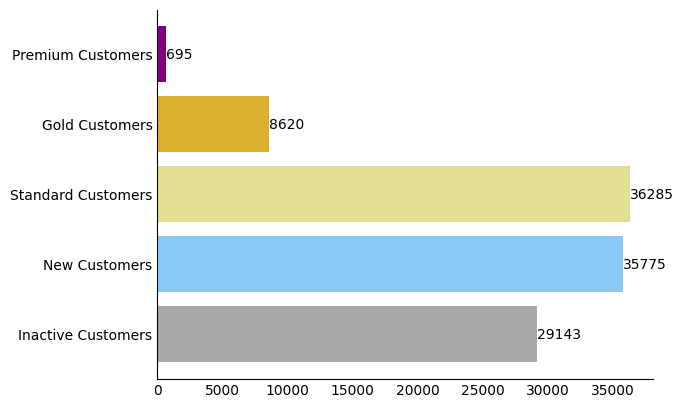

In [478]:
df['cluster'] = cluster
print(centers_df)

labels = {
    0 : 'Inactive Customers',
    1 : 'New Customers',
    2 : 'Gold Customers',
    3 : 'Standard Customers',
    4 : 'Premium Customers'
}
df['cluster_label'] = df['cluster'].map(labels)
cluster_counts = df['cluster_label'].value_counts()
order = ['Inactive Customers', 'New Customers', 'Standard Customers', 'Gold Customers','Premium Customers']
cluster_counts = cluster_counts.loc[order]
bars = plt.barh(cluster_counts.index, cluster_counts.values,
                color=['darkgray','#8bcaf7', '#e3df94', '#dbb132', 'purple'])
for b in bars:
    plt.text(b.get_width(), b.get_y() + b.get_height() /2,
            f'{int(b.get_width())}',
            va='center'
    )
hide_ticks_frame()
plt.show()

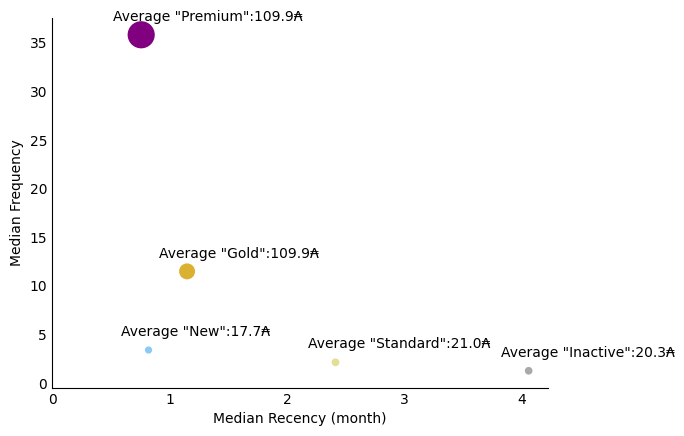

In [505]:
average_spent = centers_df['total_spent']
fig, ax = plt.subplots()
ax.scatter(centers_df['last_purchase'], centers_df['frequency'],
           s=average_spent, c = ['darkgray', '#8bcaf7', '#dbb132','#e3df94', 'purple'])
hide_ticks_frame()
plt.xticks(range(0, 5, 1))

plt.xlabel('Median Recency (month)')
plt.ylabel('Median Frequency')
mark_labels = [
               f'Average \"Inactive\":{round(average_spent[0], 1)}₳',
               f"Average \"New\":{round(average_spent[1], 1)}₳",
               f"Average \"Gold\":{round(average_spent[2], 1)}₳",
               f"Average \"Standard\":{round(average_spent[3], 1)}₳",
               f"Average \"Premium\":{round(average_spent[2], 1)}₳",
            ]
for i, txt in enumerate(mark_labels):
    plt.annotate(txt, (centers_df['last_purchase'][i], centers_df['frequency'][i],),
                 xytext=(-20, 10),textcoords='offset points')